TV-Regularized Sparse-View CT Reconstruction (Multiple Projectors, Common Sinogram)
===================================================================================

This example demonstrates solution of a sparse-view CT reconstruction
problem with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $C$ is a 2D finite difference operator, and
$\mathbf{x}$ is the desired image. The solution is computed and compared
for all three 2D CT projectors available in scico, using a sinogram
computed with the svmbir projector.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray import Parallel2dProjector, XRayTransform, astra, svmbir
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)

Define CT geometry and construct array of (approximately) equivalent projectors.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
projectors = {
    "astra": astra.XRayTransform(x_gt.shape, 1, N, angles - np.pi / 2.0),  # astra
    "svmbir": svmbir.XRayTransform(x_gt.shape, 2 * np.pi - angles, N),  # svmbir
    "scico": XRayTransform(Parallel2dProjector((N, N), angles, det_count=N)),  # scico
}

Compute common sinogram using svmbir projector.

In [4]:
A = projectors["svmbir"]
noise = np.random.normal(size=(n_projection, N)).astype(np.float32)
y = A @ x_gt + 2.0 * noise

Solve the same problem using the different projectors.

In [5]:
print(f"Solving on {device_info()}")
x_rec, hist = {}, {}
for p in ("astra", "svmbir", "scico"):
    print(f"\nSolving with {p} projector")

    # Set up ADMM solver object.
    λ = 2e0  # L1 norm regularization parameter
    ρ = 5e0  # ADMM penalty parameter
    maxiter = 25  # number of ADMM iterations
    cg_tol = 1e-4  # CG relative tolerance
    cg_maxiter = 25  # maximum CG iterations per ADMM iteration

    # The append=0 option makes the results of horizontal and vertical
    # finite differences the same shape, which is required for the L21Norm,
    # which is used so that g(Cx) corresponds to isotropic TV.
    C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
    g = λ * functional.L21Norm()
    A = projectors[p]
    f = loss.SquaredL2Loss(y=y, A=A)
    x0 = snp.clip(A.T(y), 0, 1.0)

    # Set up the solver.
    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[ρ],
        x0=x0,
        maxiter=maxiter,
        subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
        itstat_options={"display": True, "period": 5},
    )

    # Run the solver.
    solver.solve()
    hist[p] = solver.itstat_object.history(transpose=True)
    x_rec[p] = snp.clip(solver.x, 0, 1.0)

Solving on CPU

Solving with astra projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  5.45e+00  8.048e+03  1.230e+02  3.491e+00     25  4.355e-04


   5  2.55e+01  3.100e+04  4.005e+01  7.860e+01     14  9.985e-05


  10  3.45e+01  3.536e+04  3.260e+01  4.952e+01     12  8.142e-05


  15  4.07e+01  3.640e+04  2.642e+01  1.439e+01      0  9.848e-05


  20  4.92e+01  3.628e+04  1.195e+01  5.287e+00      0  6.236e-05


  24  5.07e+01  3.663e+04  1.081e+01  4.622e+00      0  8.501e-05

Solving with svmbir projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.04e+01  5.919e+03  1.253e+02  5.991e+00     25  5.328e-04


   5  1.13e+02  3.272e+04  3.783e+01  8.436e+01     17  8.241e-05


  10  1.49e+02  3.662e+04  2.699e+01  4.670e+01     13  9.227e-05


  15  1.73e+02  3.746e+04  1.358e+01  6.594e+00      2  8.150e-05


  20  1.99e+02  3.747e+04  1.858e+01  3.658e+01     12  8.725e-05


  24  2.15e+02  3.759e+04  2.469e+01  1.684e+01      0  9.652e-05

Solving with scico projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.71e+00  1.072e+04  2.091e+02  5.556e+01     25  5.500e-04


   5  2.02e+01  6.703e+04  3.871e+01  1.047e+02     15  9.175e-05


  10  2.71e+01  6.886e+04  1.787e+01  1.235e+01      0  9.903e-05


  15  3.21e+01  6.927e+04  2.690e+01  7.917e+01     15  8.323e-05


  20  3.65e+01  6.951e+04  1.135e+01  5.088e+00      0  8.780e-05


  24  3.93e+01  6.963e+04  2.279e+01  1.631e+01      0  9.286e-05


Display sinogram.

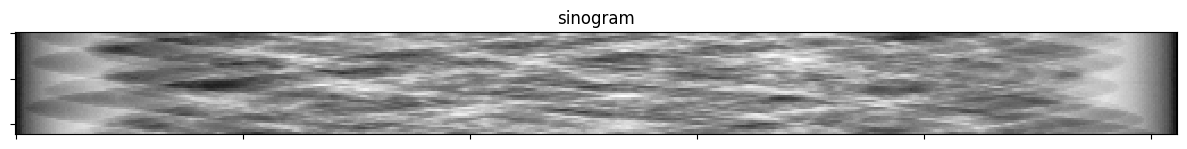

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=1, figsize=(15, 3))
plot.imview(y, title="sinogram", fig=fig, ax=ax)
fig.show()

Plot convergence statistics.

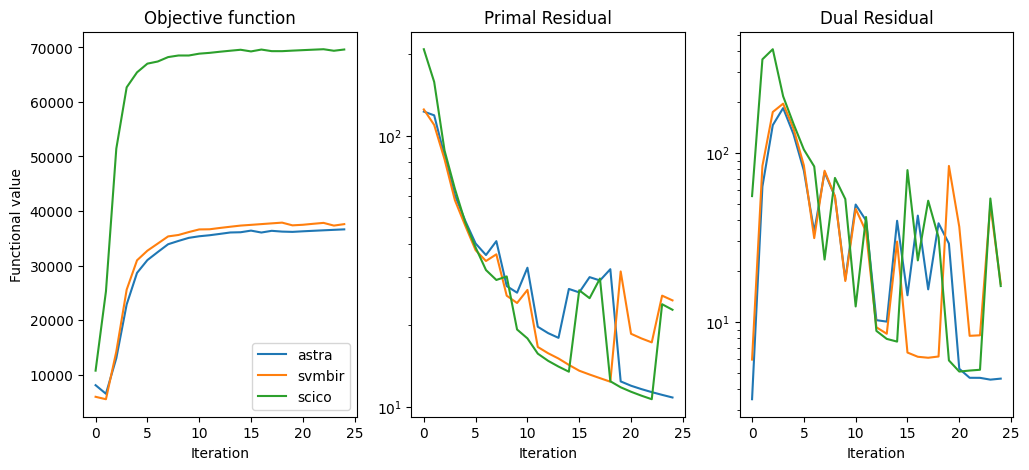

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(12, 5))
plot.plot(
    np.vstack([hist[p].Objective for p in projectors.keys()]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=projectors.keys(),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack([hist[p].Prml_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.vstack([hist[p].Dual_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[2],
)
fig.show()

Show the recovered images.

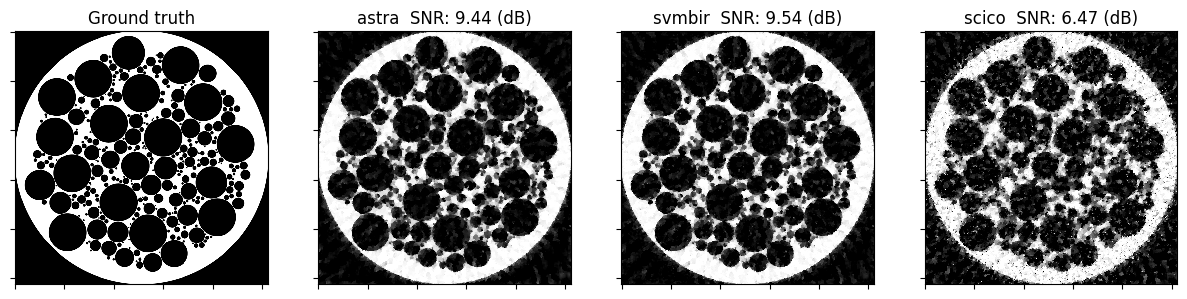

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=4, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
for n, p in enumerate(projectors.keys()):
    plot.imview(
        x_rec[p],
        title="%s  SNR: %.2f (dB)" % (p, metric.snr(x_gt, x_rec[p])),
        fig=fig,
        ax=ax[n + 1],
    )
fig.show()